## Global statistics

Here we produce binned maps of different properties measured by the GDP dataset. 

In [2]:
import xarray as xr
import numpy as np
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean

In [3]:
#path_gdp = 'data/gdp_subset.nc'
path_gdp = 'data/gdp_fullset.nc'
ds = xr.open_dataset(path_gdp, chunks={}) # chunks={} to automatically select chunks size

In [4]:
ds.load()

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ID                     (traj) int64 2578 2582 2583 ... 61493010 61493020
    lon                    (obs) float32 -47.95 -47.96 -47.96 ... 32.84 32.84
    lat                    (obs) float32 47.48 47.47 47.45 ... -25.54 -25.54
    time                   (obs) datetime64[ns] 2005-04-15T20:00:00 ... 2016-...
    ids                    (obs) int64 2578 2578 2578 ... 61493020 61493020
Dimensions without coordinates: traj, obs
Data variables: (12/54)
    rowsize                (traj) int64 5137 4289 1024 1095 ... 14769 16695 5209
    location_type          (traj) bool False False False ... True True True
    WMO                    (traj) int32 4400505 4400506 0 ... 1601501 1601502
    expno                  (traj) int32 9046 9046 46 9046 ... 20921 20921 20921
    deploy_date            (traj) datetime64[ns] 2005-04-15 ... 2016-04-09
    deploy_lon             (traj) float32 -48.0 -52.0 -50.02 ... 65.0 75.4 54.3
    ...                     ...
    err_sst                (obs) float32 0.013 0.011 0.011 0.012 ... nan nan nan
    err_sst1               (obs) float32 0.033 0.023 0.015 0.011 ... nan nan nan
    err_sst2               (obs) float32 0.03 0.027 0.021 0.016 ... nan nan nan
    flg_sst                (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0 0 0
    flg_sst1               (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0 0 0
    flg_sst2               (obs) int8 5 5 5 5 2 2 2 5 5 5 ... 0 0 0 0 0 0 0 0 0
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-06-27T13:53:17.908246
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

In [5]:
ds_drogued = ds.where(ds.drogue_status==1, drop=True)

MemoryError: Unable to allocate 8.34 TiB for an array with shape (17324, 66177435) and data type float64

In [7]:
ds_locs_only = xr.Dataset()
ds_locs_only['drogue_status'] = ds.drogue_status
ds_locs_only['lon'] = ds.lon
ds_locs_only['lat'] = ds.lat


In [9]:
ds_drogued = ds_locs_only.where(ds_locs_only.drogue_status==1, drop=True)

In [14]:
ds['lon'].shape, ds_drogued['lon'].shape

((165754333,), (66177435,))

In [18]:
(165754333. - 66177435)/66177435.

1.5046956413466313

In [19]:
# make 1 dgree by 1 degree bins
lon = np.linspace(-180, 180, 120)
lat = np.linspace(-90, 90, 90)

In [20]:
# Zonal mean velocity
Ubar = stats.binned_statistic_2d(ds.lon, 
                                ds.lat,
                                ds.ve,
                                statistic=np.nanmean, 
                                bins=[lon, lat])

In [21]:
# Meridional mean velocity
Vbar = stats.binned_statistic_2d(ds.lon, 
                                ds.lat,
                                ds.vn,
                                statistic=np.nanmean, 
                                bins=[lon, lat])

In [22]:
Uvar = stats.binned_statistic_2d(ds.lon, 
                                ds.lat,
                                ds.ve,
                                statistic=np.nanvar, 
                                bins=[lon, lat])

Vvar = stats.binned_statistic_2d(ds.lon, 
                                ds.lat,
                                ds.vn,
                                statistic=np.nanvar, 
                                bins=[lon, lat])

In [23]:
EKE = 0.5*(Uvar.statistic + Vvar.statistic)

In [24]:
count = stats.binned_statistic_2d(ds.lon, 
                                ds.lat,
                                ds.ve,
                                'count', 
                                bins=[lon, lat])

In [25]:
count_drogued = stats.binned_statistic_2d(ds_drogued.lon, 
                                ds_drogued.lat,
                                ds_drogued.lon,
                                'count', 
                                bins=[lon, lat])

In [26]:
x_c = 0.5*(lon[:-1] + lon[1:])
y_c = 0.5*(lat[:-1] + lat[1:])

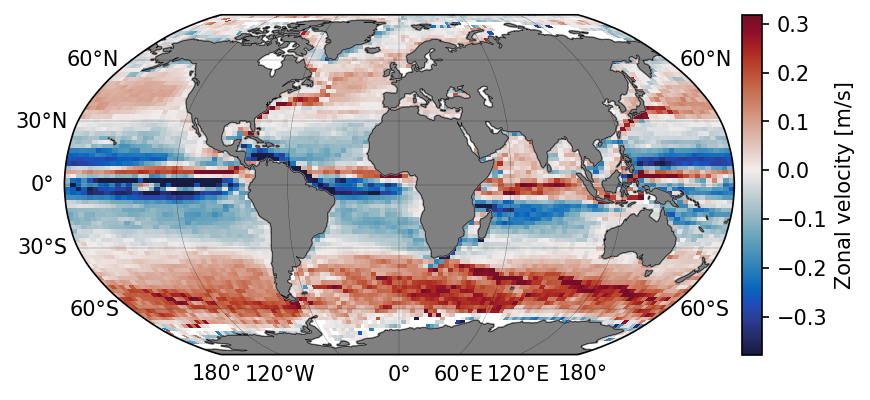

In [27]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(Ubar.statistic.T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
cmap = cmocean.tools.crop(cmocean.cm.balance, vmin=v1, vmax=v2, pivot=0)
pcm = ax.pcolormesh(x_c, y_c, 
                    Ubar.statistic.T, 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Zonal velocity [m/s]');

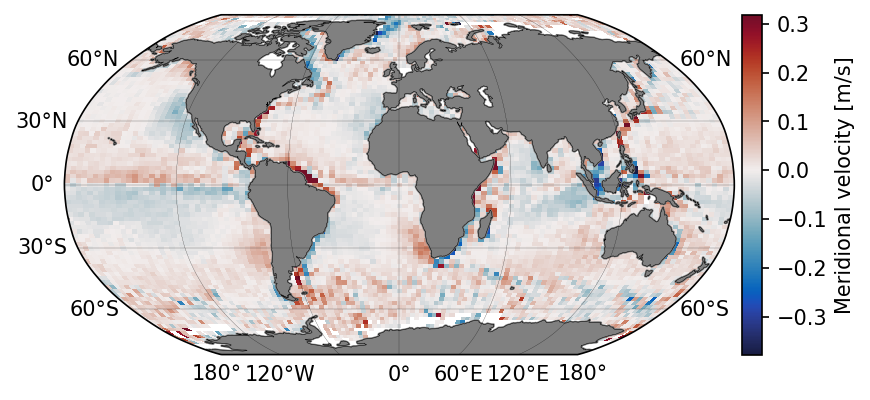

In [28]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
#v1,v2 = np.nanpercentile(Vbar.statistic.T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
cmap = cmocean.tools.crop(cmocean.cm.balance, vmin=v1, vmax=v2, pivot=0)
pcm = ax.pcolormesh(x_c, y_c, 
                    Vbar.statistic.T, 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Meridional velocity [m/s]');

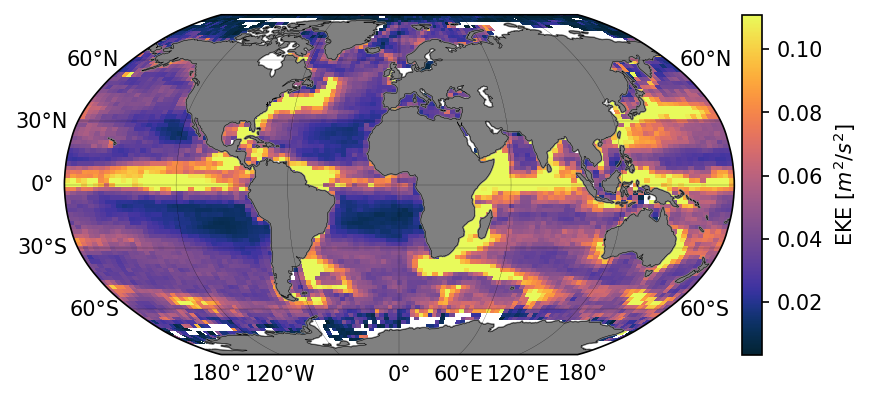

In [29]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(EKE.T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
#cmap = cmocean.tools.crop(cmocean.cm.matter_r, vmin=0, vmax=v2, pivot=0)
cmap = cmocean.cm.thermal
pcm = ax.pcolormesh(x_c, y_c, 
                    EKE.T, 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2/2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel(r'EKE [$m^2/s^2$]');

/tmp/ipykernel_87545/1957518239.py:2: RuntimeWarning: divide by zero encountered in log10
  v1,v2 = np.nanpercentile(np.log10(EKE).T,[1,99])
/tmp/ipykernel_87545/1957518239.py:9: RuntimeWarning: divide by zero encountered in log10
  np.log10(EKE).T,


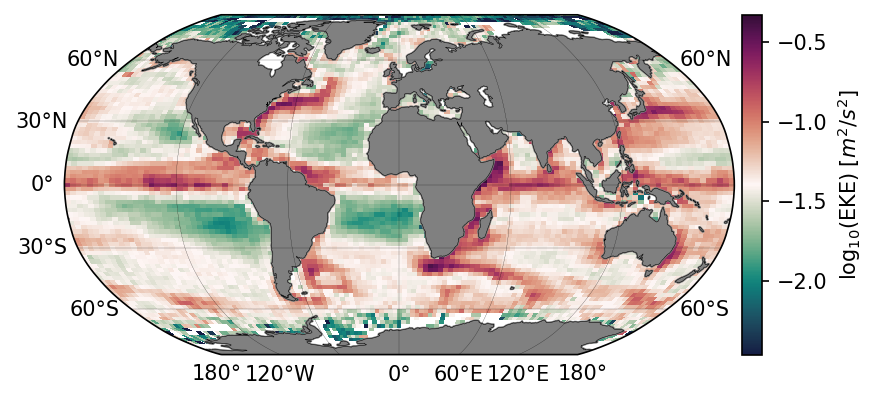

In [30]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(np.log10(EKE).T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
#cmap = cmocean.tools.crop(cmocean.cm.matter_r, vmin=0, vmax=v2, pivot=0)
cmap = cmocean.cm.curl#thermal
pcm = ax.pcolormesh(x_c, y_c, 
                    np.log10(EKE).T, 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2/2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel(r'log$_{10}$(EKE) [$m^2/s^2$]');


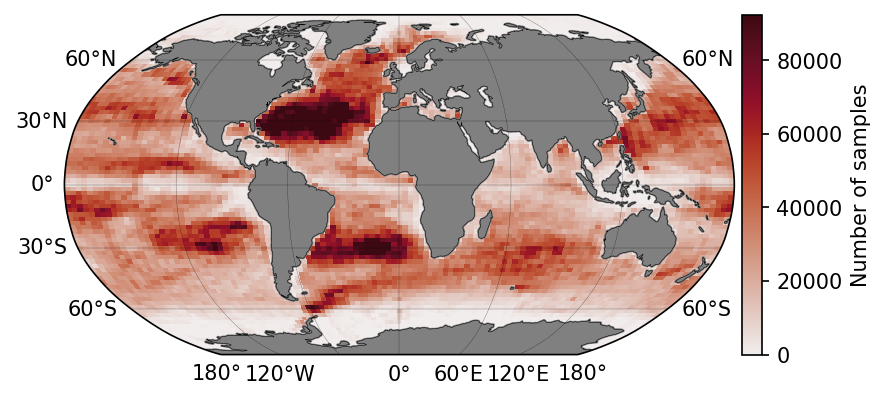

In [33]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(count.statistic.T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
#cmap = cmocean.tools.crop(cmocean.cm.thermal, vmin=v1, vmax=v2, pivot=0)
cmap = cmocean.cm.amp
pcm = ax.pcolormesh(x_c, y_c, 
                    count.statistic.T, 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Number of samples');
plt.savefig('nsamp_map.pdf')

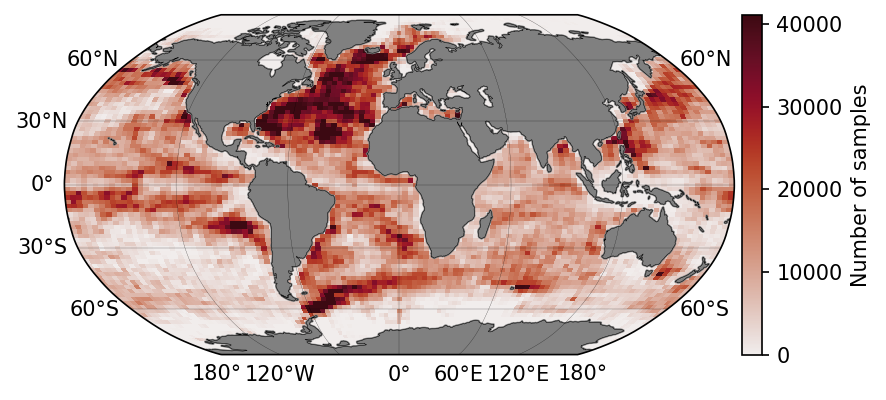

In [32]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(count_drogued.statistic.T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
#cmap = cmocean.tools.crop(cmocean.cm.thermal, vmin=v1, vmax=v2, pivot=0)
cmap = cmocean.cm.amp
pcm = ax.pcolormesh(x_c, y_c, 
                    count_drogued.statistic.T, 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Number of samples');

In [24]:
ds_stats = xr.Dataset()

In [33]:
ds_stats['Ubar'] = xr.DataArray(Ubar.statistic.T, dims=['lat', 'lon'], coords={'lon':x_c, 'lat':y_c} )
ds_stats['Vbar'] = xr.DataArray(Vbar.statistic.T, dims=['lat', 'lon'], coords={'lon':x_c, 'lat':y_c} )
ds_stats['EKE'] = xr.DataArray(EKE.T, dims=['lat', 'lon'], coords={'lon':x_c, 'lat':y_c} )
ds_stats['num_samples'] = xr.DataArray(count.statistic.T, dims=['lat', 'lon'], coords={'lon':x_c, 'lat':y_c} )
ds_stats['num_samples_drogued'] = xr.DataArray(count_drogued.statistic.T, dims=['lat', 'lon'], coords={'lon':x_c, 'lat':y_c} )

In [34]:
ds_stats

<xarray.Dataset>
Dimensions:      (lon: 119, lat: 89)
Coordinates:
  * lon          (lon) float64 -178.5 -175.5 -172.4 -169.4 ... 172.4 175.5 178.5
  * lat          (lat) float64 -88.99 -86.97 -84.94 -82.92 ... 84.94 86.97 88.99
Data variables:
    Ubar         (lat, lon) float64 nan nan nan ... -0.002967 -0.01778 -0.002087
    Vbar         (lat, lon) float64 nan nan nan nan ... 0.2342 0.1151 0.07806
    EKE          (lat, lon) float64 nan nan nan nan ... 0.01941 0.01736 0.0172
    num_samples  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 7.0 18.0 87.0 45.0

In [35]:
ds_stats.to_netcdf('./data/binned_stats.nc')

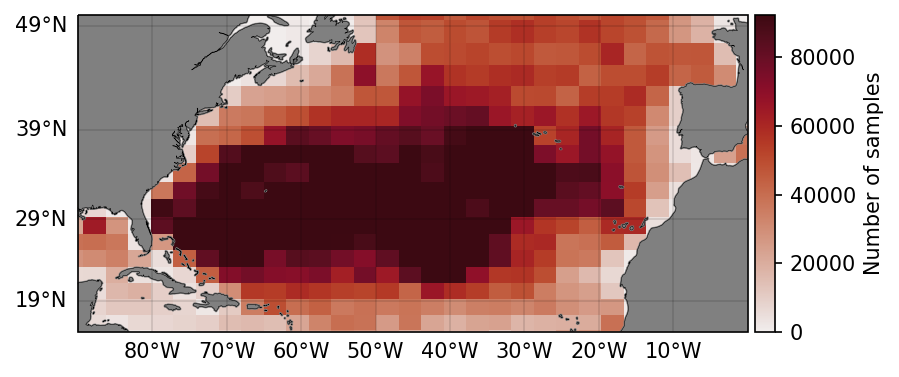

In [51]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(count.statistic.T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(central_longitude=0,
                                                    min_latitude=15,
                                                    max_latitude=50,
                                                    ))
#cmap = cmocean.tools.crop(cmocean.cm.thermal, vmin=v1, vmax=v2, pivot=0)
cmap = cmocean.cm.amp
pcm = ax.pcolormesh(x_c, y_c, 
                    count.statistic.T, 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 10), ylocs=np.arange(-91, 90, 10),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False


ax.set_extent([-90, 0, 15, 50])

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Number of samples');

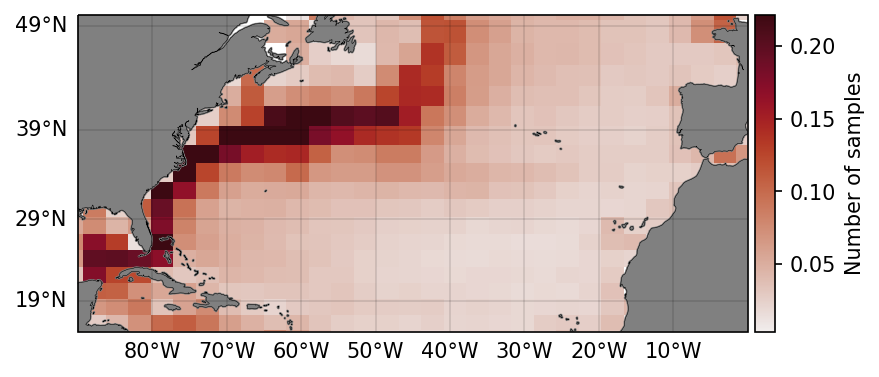

In [53]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(ds_stats['EKE'],[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(central_longitude=0,
                                                    min_latitude=15,
                                                    max_latitude=50,
                                                    ))
#cmap = cmocean.tools.crop(cmocean.cm.thermal, vmin=v1, vmax=v2, pivot=0)
cmap = cmocean.cm.amp
pcm = ax.pcolormesh(x_c, y_c, 
                    ds_stats['EKE'], 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 10), ylocs=np.arange(-91, 90, 10),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False


ax.set_extent([-90, 0, 15, 50])

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Number of samples');

In [ ]:
# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
v1,v2 = np.nanpercentile(ds_stats['EKE'],[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator(central_longitude=0,
                                                    min_latitude=15,
                                                    max_latitude=50,
                                                    ))
#cmap = cmocean.tools.crop(cmocean.cm.thermal, vmin=v1, vmax=v2, pivot=0)
cmap = cmocean.cm.amp
pcm = ax.pcolormesh(x_c, y_c, 
                    ds_stats['EKE'], 
                    cmap=cmap, 
                    transform=ccrs.PlateCarree(),
                    vmin=v1, vmax=v2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 10), ylocs=np.arange(-91, 90, 10),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False


ax.set_extent([-90, 0, 15, 50])

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Number of samples');